In [1]:
import torch
import networkx as nx
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
import sys  
sys.path.append('../Selection/')
from op_iter import *
from op_torch import *
from greedy_css import *
from func_utils import *

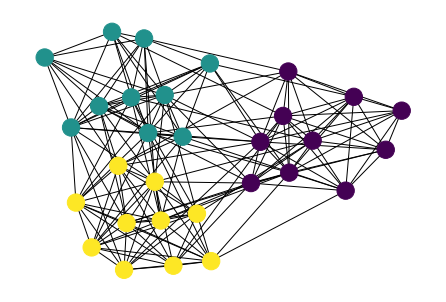

In [2]:
# Generate data using SBM model and assign node features
block_size = [10,10,10]
num_channels = 10 # dimension of features for each node
edge_probs = [[0.9,0.2,0.2], [0.2,0.9,0.2], [0.2,0.2,0.9]]
dataset= StochasticBlockModelDataset(root='SBM', block_sizes = block_size, num_channels=3, edge_probs = edge_probs)
data = dataset[0]
# Transform to adjacency matrix and compute Laplacian matrix for future use
A = to_dense_adj(data.edge_index).reshape(sum(block_size),sum(block_size)) # N*N
D = torch.sum(A, dim=1)
L = D-A
# Compute the minimum path length between two nodes for future use
G = to_networkx(data, to_undirected=True) 
dic = dict(nx.all_pairs_shortest_path_length(G))
dist = torch.zeros_like(A)
for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
        dist[i,j] = dic[i][j]
# Visualize the generated graph
nx.all_pairs_shortest_path_length(G)
nx.draw(G, node_color=data.y)

In [3]:
alpha = 100
lamda = 1
W, loss = CUR_torch_solver(data.x, dist, alpha, lamda, method='dist', epochs=1000, learning_rate=1e-1, print=False)
# Column sum
print(torch.max(W.abs(), dim=0).values)
print(loss) # smaller than other learning rates

tensor([0.0126, 0.0072, 0.0296, 0.0193, 0.0191, 0.0122, 0.0139, 0.0184, 0.0178,
        0.0105, 0.0169, 0.0157, 0.0156, 0.0142, 0.0091, 0.0085, 0.0156, 0.0143,
        0.0123, 0.0140, 0.0095, 0.0150, 0.0238, 0.0122, 0.0123, 0.0093, 0.0133,
        0.0085, 0.0273, 0.0177], grad_fn=<MaxBackward0>)
tensor(258.0501, grad_fn=<AddBackward0>)


In [17]:
alpha = 100
lamda = 1
W, loss = CUR_torch_solver(data.x, L, alpha, lamda, method='Lap', epochs=1000, learning_rate=1e-1, print=False)
# Column sum
print(torch.max(W.abs(), dim=0).values)
print(loss) # smaller than other learning rates

tensor([1.4314e-04, 2.2635e-04, 8.4931e-05, 1.1390e-04, 2.1158e-04, 2.1141e-04,
        1.8310e-04, 7.9883e-05, 1.1178e-04, 3.0620e-04, 3.0582e-04, 3.1222e-04,
        3.1406e-04, 2.0232e-04, 3.0315e-04, 1.4814e-04, 9.5253e-05, 2.8977e-05,
        2.7931e-04, 5.5018e-05, 1.7203e-04, 1.7372e-04, 3.4341e-04, 5.3228e-05,
        1.1320e-04, 3.3562e-04, 2.9448e-04, 3.2880e-04, 8.4234e-05, 2.8845e-04],
       grad_fn=<MaxBackward0>)
tensor(183.5825, grad_fn=<AddBackward0>)


In [19]:
alpha = 100
lamda = 1
epsilon = 0.01
W, W_tilde, W_hat, loss, rho_1, rho_2 = CUR_iter_solver(X=data.x, T=dist, alpha=alpha, lamda=lamda, epsilon=epsilon, initial_rho=1e-3, \
    max_rho=1e10, tau=1.1, set_seed=False)
print(torch.max(W.abs(), dim=0).values)
print(loss) # smaller than other learning rates 

tensor([6.8546e-06, 1.2765e-06, 7.5015e-07, 2.4066e-06, 2.1119e-06, 1.0955e-06,
        4.6386e-06, 9.2734e-07, 5.0100e-06, 1.7509e-06, 6.2041e-06, 2.6754e-06,
        2.7237e-06, 8.1019e-07, 1.3256e-06, 2.2701e-06, 4.1402e-06, 4.4085e-07,
        3.1390e-06, 2.2284e-06, 1.7489e-06, 1.7571e-06, 1.0295e-06, 2.1120e-06,
        4.5998e-06, 3.7450e-06, 2.8973e-06, 1.5642e-06, 9.2835e-07, 9.0564e-07])
tensor(182.6495)


In [13]:
alpha = 100
lamda = 1
epsilon = 0.01
# bad initial value
W, W_tilde, W_hat, loss, rho_1, rho_2 = CUR_iter_solver(X=data.x, T=dist, alpha=alpha, lamda=lamda, epsilon=epsilon, initial_rho=1e-6, \
    max_rho=1e10, tau=1.1, set_seed=False)
print(torch.max(W.abs(), dim=0).values)
print(loss) # smaller than other learning rates 

tensor([1.3672e+15, 7.9807e+14, 1.0044e+15, 2.4654e+14, 2.1533e+14, 3.1700e+14,
        8.9946e+14, 1.9012e+14, 1.7659e+15, 2.0840e+14, 1.8325e+15, 5.1597e+14,
        7.7652e+14, 4.8525e+14, 2.6500e+14, 4.2396e+14, 2.1695e+13, 3.3226e+14,
        1.0396e+13, 1.3380e+14, 3.2750e+14, 6.7257e+14, 1.8966e+14, 3.1342e+14,
        1.8156e+14, 8.6519e+12, 2.9820e+14, 3.4528e+14, 1.9425e+14, 1.6200e+15])
tensor(9.9992e+21)


In [6]:
alpha = 1
lamda = 1
W, loss = CUR_torch_solver(data.x, dist, alpha, lamda, method='dist', epochs=1000, learning_rate=1e-2, print=False)
# Column sum
print(torch.max(W.abs(), dim=0).values)
print(loss) # smaller than other learning rates

tensor([0.9699, 0.5890, 0.5904, 0.8912, 0.4046, 0.1927, 0.9523, 0.2774, 0.9669,
        0.5988, 0.9590, 0.8946, 0.7691, 0.2954, 0.8289, 0.2873, 0.9415, 0.1451,
        0.7286, 0.0201, 0.6933, 0.7710, 0.6458, 0.3678, 0.9541, 0.9441, 0.7386,
        0.3961, 0.4778, 0.9122], grad_fn=<MaxBackward0>)
tensor(27.8192, grad_fn=<AddBackward0>)


In [21]:
alpha = 1
lamda = 1
W, W_tilde, W_hat, loss, rho_1, rho_2 = CUR_iter_solver(X=data.x, T=dist, alpha=alpha, lamda=lamda, epsilon=epsilon, initial_rho=1e-3, \
    max_rho=1e10, tau=1.1, set_seed=False)
print(torch.max(W.abs(), dim=0).values)
print(loss) 

tensor([9.7429e-01, 2.7006e-01, 3.4771e-01, 9.1543e-01, 1.1119e-04, 2.1999e-05,
        9.5886e-01, 2.5785e-05, 9.7316e-01, 3.1951e-01, 9.6522e-01, 9.1182e-01,
        6.5617e-01, 2.4896e-05, 8.6153e-01, 2.5093e-05, 9.6297e-01, 1.7004e-05,
        5.3143e-01, 1.1045e-05, 4.6165e-01, 6.1608e-01, 4.6226e-01, 3.0189e-05,
        9.6241e-01, 9.5772e-01, 5.5578e-01, 8.0988e-02, 1.4987e-01, 9.3175e-01])
tensor(27.8650)


In [7]:
sel = greedy_CSS(data.x.t(), k=10, c=None)
print('Selection for X:', sel)
AX = torch.matmul(A, data.x)
AAX = torch.matmul(A, AX)
sel_AX = greedy_CSS(AX.t(), k=10, c=None)
print('Selection for AX:', sel_AX)
sel_AAX = greedy_CSS(AAX.t(), k=10, c=None)
print('Selection for AAX:', sel_AAX)


Selection for X: tensor([18., 17., 16.,  3.,  0.,  1.,  2.,  4.,  5.,  6.])
Selection for AX: tensor([14., 15.,  6., 19.,  0.,  1.,  2.,  3.,  4.,  5.])
Selection for AAX: tensor([19., 24., 28.,  2.,  0.,  1.,  3.,  4.,  5.,  6.])


/Users/liushuhan/Documents/Research in second year/Experiments/RSP/Experiment/../Selection/greedy_css.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ratio[torch.tensor(L[:t], dtype=torch.long)] = 0 # remove previously selected nodes
